# Импорт необходимых библиотек

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('./data/Physical_Activity_Monitoring_unlabeled.csv')
df.sort_values(by='timestamp', inplace=True)

# Предпроцессинг данных

In [3]:
# В первую очередь заполним пустые значения

missing_values = df.isnull().sum()  # Количество пропусков
total_rows = len(df)  # Общее число строк
missing_data = missing_values[missing_values > 0].to_frame(name="Missing Count")
missing_data["Missing Percentage"] = (missing_data["Missing Count"] / total_rows) * 100

missing_data

,Missing Count,Missing Percentage
handTemperature,4041,0.755891
handAcc16_1,4041,0.755891
handAcc16_2,4041,0.755891
handAcc16_3,4041,0.755891
handAcc6_1,4041,0.755891
handAcc6_2,4041,0.755891
handAcc6_3,4041,0.755891
handGyro1,4041,0.755891
handGyro2,4041,0.755891
handGyro3,4041,0.755891


Видно, что пропусков очень много. Мы знаем, что это временной ряд, следовательно, логично заполнить данные с учетом временной составляющей. Для начала посмотрим, как выглядят данные пропуски

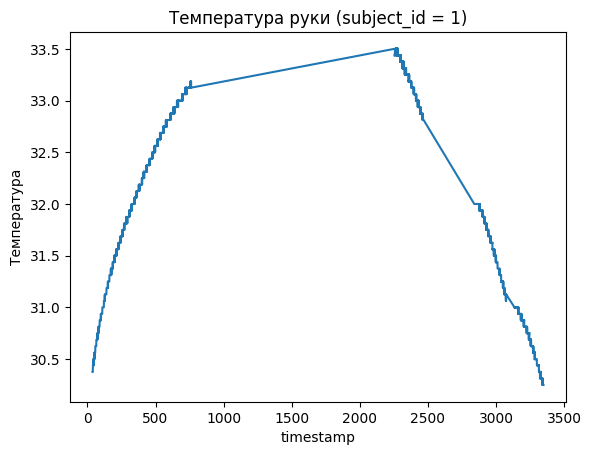

In [4]:
first = df.loc[df['subject_id'] == 1].copy()

first = first.sort_values(by='timestamp')
first = first.set_index('timestamp')

first['handTemperature'].plot()
plt.title('Температура руки (subject_id = 1)')
plt.ylabel('Температура')
plt.show()

Из графика видно, что данные гладкие, следовательно, пробуем заполнить их кубическими сплайнами.

In [5]:
for i in df['subject_id'].unique():
    mask = df['subject_id'] == i
    df.loc[mask, 'handTemperature'] = df.loc[mask, 'handTemperature'].interpolate(method='cubic', limit_direction='both')
    df.loc[mask, 'chestTemperature'] = df.loc[mask, 'chestTemperature'].interpolate(method='cubic', limit_direction='both')
    df.loc[mask, 'ankleTemperature'] = df.loc[mask, 'ankleTemperature'].interpolate(method='cubic', limit_direction='both')

In [6]:
df.loc[df['ankleTemperature'].isna()==True]

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id


Пропуски в handTemperature теперь отсутствуют, график остался почти неизменным. Далее проанализируем пропуски в данных 3D-ускорения.

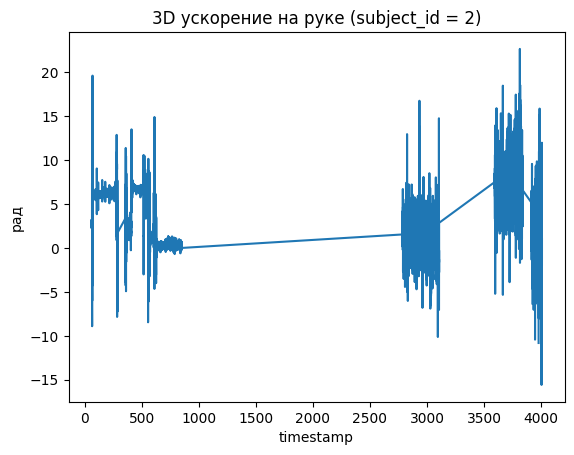

In [7]:
first = df.loc[df['subject_id'] == 2].copy()

first = first.sort_values(by='timestamp')
first = first.set_index('timestamp')

first['handAcc16_3'].plot()
plt.title('3D ускорение на руке (subject_id = 2)')
plt.ylabel('рад')
plt.show()

Учитывая, что в данных больше выбросов, попробуем сделать сплайн линейным методом.

In [8]:
for i in df['subject_id'].unique():
    mask = df['subject_id'] == i
    # 3D на руке
    df.loc[mask, 'handAcc16_1'] = df.loc[mask, 'handAcc16_1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handAcc16_2'] = df.loc[mask, 'handAcc16_2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handAcc16_3'] = df.loc[mask, 'handAcc16_3'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handAcc6_1'] = df.loc[mask, 'handAcc6_1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handAcc6_2'] = df.loc[mask, 'handAcc6_2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handAcc6_3'] = df.loc[mask, 'handAcc6_3'].interpolate(method='linear', limit_direction='both')
    # 3D на груди
    df.loc[mask, 'chestAcc16_1'] = df.loc[mask, 'chestAcc16_1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestAcc16_2'] = df.loc[mask, 'chestAcc16_2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestAcc16_3'] = df.loc[mask, 'chestAcc16_3'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestAcc6_1'] = df.loc[mask, 'chestAcc6_1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestAcc6_2'] = df.loc[mask, 'chestAcc6_2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestAcc6_3'] = df.loc[mask, 'chestAcc6_3'].interpolate(method='linear', limit_direction='both')
    # 3D на ноге
    df.loc[mask, 'ankleAcc16_1'] = df.loc[mask, 'ankleAcc16_1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleAcc16_2'] = df.loc[mask, 'ankleAcc16_2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleAcc16_3'] = df.loc[mask, 'ankleAcc16_3'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleAcc6_1'] = df.loc[mask, 'ankleAcc6_1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleAcc6_2'] = df.loc[mask, 'ankleAcc6_2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleAcc6_3'] = df.loc[mask, 'ankleAcc6_3'].interpolate(method='linear', limit_direction='both')
    

In [9]:
df.loc[df['handAcc6_1'].isna()==True]

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id


Займемся гироскопом и магитометром.

C:\Users\raven\AppData\Local\Temp\ipykernel_37080\1993095610.py:6: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  first['handMagne1'][0:1000].plot()


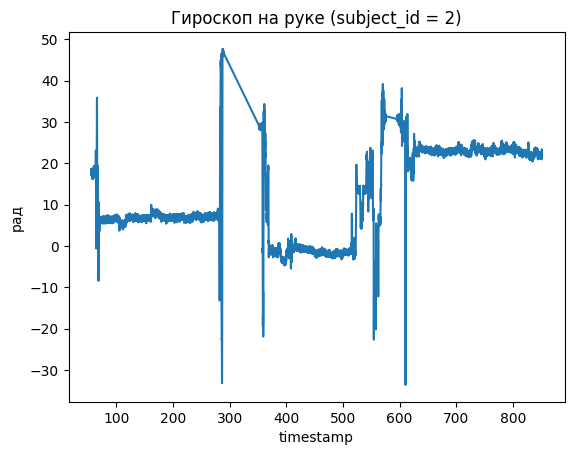

In [10]:
first = df.loc[df['subject_id'] == 2].copy()

first = first.sort_values(by='timestamp')
first = first.set_index('timestamp')

first['handMagne1'][0:1000].plot()
plt.title('Гироскоп на руке (subject_id = 2)')
plt.ylabel('рад')
plt.show()

Данные не сильно отличаются, применим тот же метод

In [11]:
for i in df['subject_id'].unique():
    mask = df['subject_id'] == i
    # 3D на руке
    df.loc[mask, 'handGyro1'] = df.loc[mask, 'handGyro1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handGyro2'] = df.loc[mask, 'handGyro2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handGyro3'] = df.loc[mask, 'handGyro3'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handMagne1'] = df.loc[mask, 'handMagne1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handMagne2'] = df.loc[mask, 'handMagne2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'handMagne3'] = df.loc[mask, 'handMagne3'].interpolate(method='linear', limit_direction='both')
    # 3D на груди
    df.loc[mask, 'chestGyro1'] = df.loc[mask, 'chestGyro1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestGyro2'] = df.loc[mask, 'chestGyro2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestGyro3'] = df.loc[mask, 'chestGyro3'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestMagne1'] = df.loc[mask, 'chestMagne1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestMagne2'] = df.loc[mask, 'chestMagne2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'chestMagne3'] = df.loc[mask, 'chestMagne3'].interpolate(method='linear', limit_direction='both')
    # 3D на ноге
    df.loc[mask, 'ankleGyro1'] = df.loc[mask, 'ankleGyro1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleGyro2'] = df.loc[mask, 'ankleGyro2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleGyro3'] = df.loc[mask, 'ankleGyro3'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleMagne1'] = df.loc[mask, 'ankleMagne1'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleMagne2'] = df.loc[mask, 'ankleMagne2'].interpolate(method='linear', limit_direction='both')
    df.loc[mask, 'ankleMagne3'] = df.loc[mask, 'ankleMagne3'].interpolate(method='linear', limit_direction='both')
    

Последнее, что следует заметить до начала разведывательного анализа, — это то, что в нашем наборе данных есть столбцы с ориентацией, которые, согласно ссылке к данным, некорректные. Почему они остались в датасете, конечно, вопрос. Удалим их.

In [12]:
df.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
    'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
    'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'], axis=1, inplace=True)

Можно было бы заняться задачей заполнения пропусков в timestamp, однако это может увеличить ошибку модели (т. к. будет еще одна модель вне ансамбля). Пропустим этот этап.

Учитывая, что данные 3D-ускорения, гироскопа и магнитометра имеют большие выбросы мы попробуем сгладить их с помощью скользящего среднего.

In [13]:
df_smoothed_list = []

for i in df['subject_id'].unique():
    # Выбираем данные для текущего субъекта
    tmp = df.loc[df['subject_id'] == i].copy()
    
    # Сортируем по времени (если ещё не отсортировано)
    tmp = tmp.sort_values('timestamp')
    
    # Разделяем данные на сглаживаемые и остальные колонки
    smooth_cols = ['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
                  'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
                  'handGyro1', 'handGyro2', 'handGyro3',
                  'handMagne1', 'handMagne2', 'handMagne3',
                  'chestTemperature', 'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                  'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
                  'chestGyro1', 'chestGyro2', 'chestGyro3',
                  'chestMagne1', 'chestMagne2', 'chestMagne3',
                  'ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
                  'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
                  'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
                  'ankleMagne1', 'ankleMagne2', 'ankleMagne3']
    
    other_cols = tmp.columns.difference(smooth_cols)
    
    # Сглаживание по времени (axis=0) с центральным окном
    smoothed_data = tmp[smooth_cols].rolling(window=20, min_periods=1, center=True).mean()
    
    # Объединяем с несглаженными данными
    result = pd.concat([
        smoothed_data,
        tmp[other_cols]
    ], axis=1)
    
    df_smoothed_list.append(result)

# Объединяем все данные
df_smoothed = pd.concat(df_smoothed_list)
df_smoothed = df_smoothed.sort_values('timestamp')

C:\Users\raven\AppData\Local\Temp\ipykernel_37080\4017001940.py:6: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  first['handMagne1'][0:1000].plot()


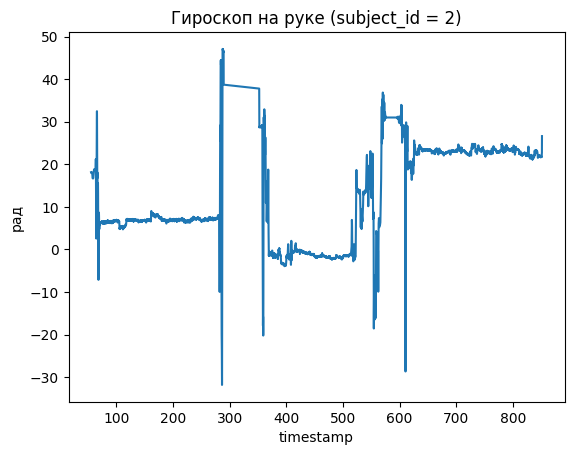

In [14]:
first = df_smoothed.loc[df_smoothed['subject_id'] == 2].copy()

first = first.sort_values(by='timestamp')
first = first.set_index('timestamp')

first['handMagne1'][0:1000].plot()
plt.title('Гироскоп на руке (subject_id = 2)')
plt.ylabel('рад')
plt.show()

# Разведывательный анализ

Начнем с того же, с чего начинался baseline решение: с матрицы корреляции.

<Axes: >

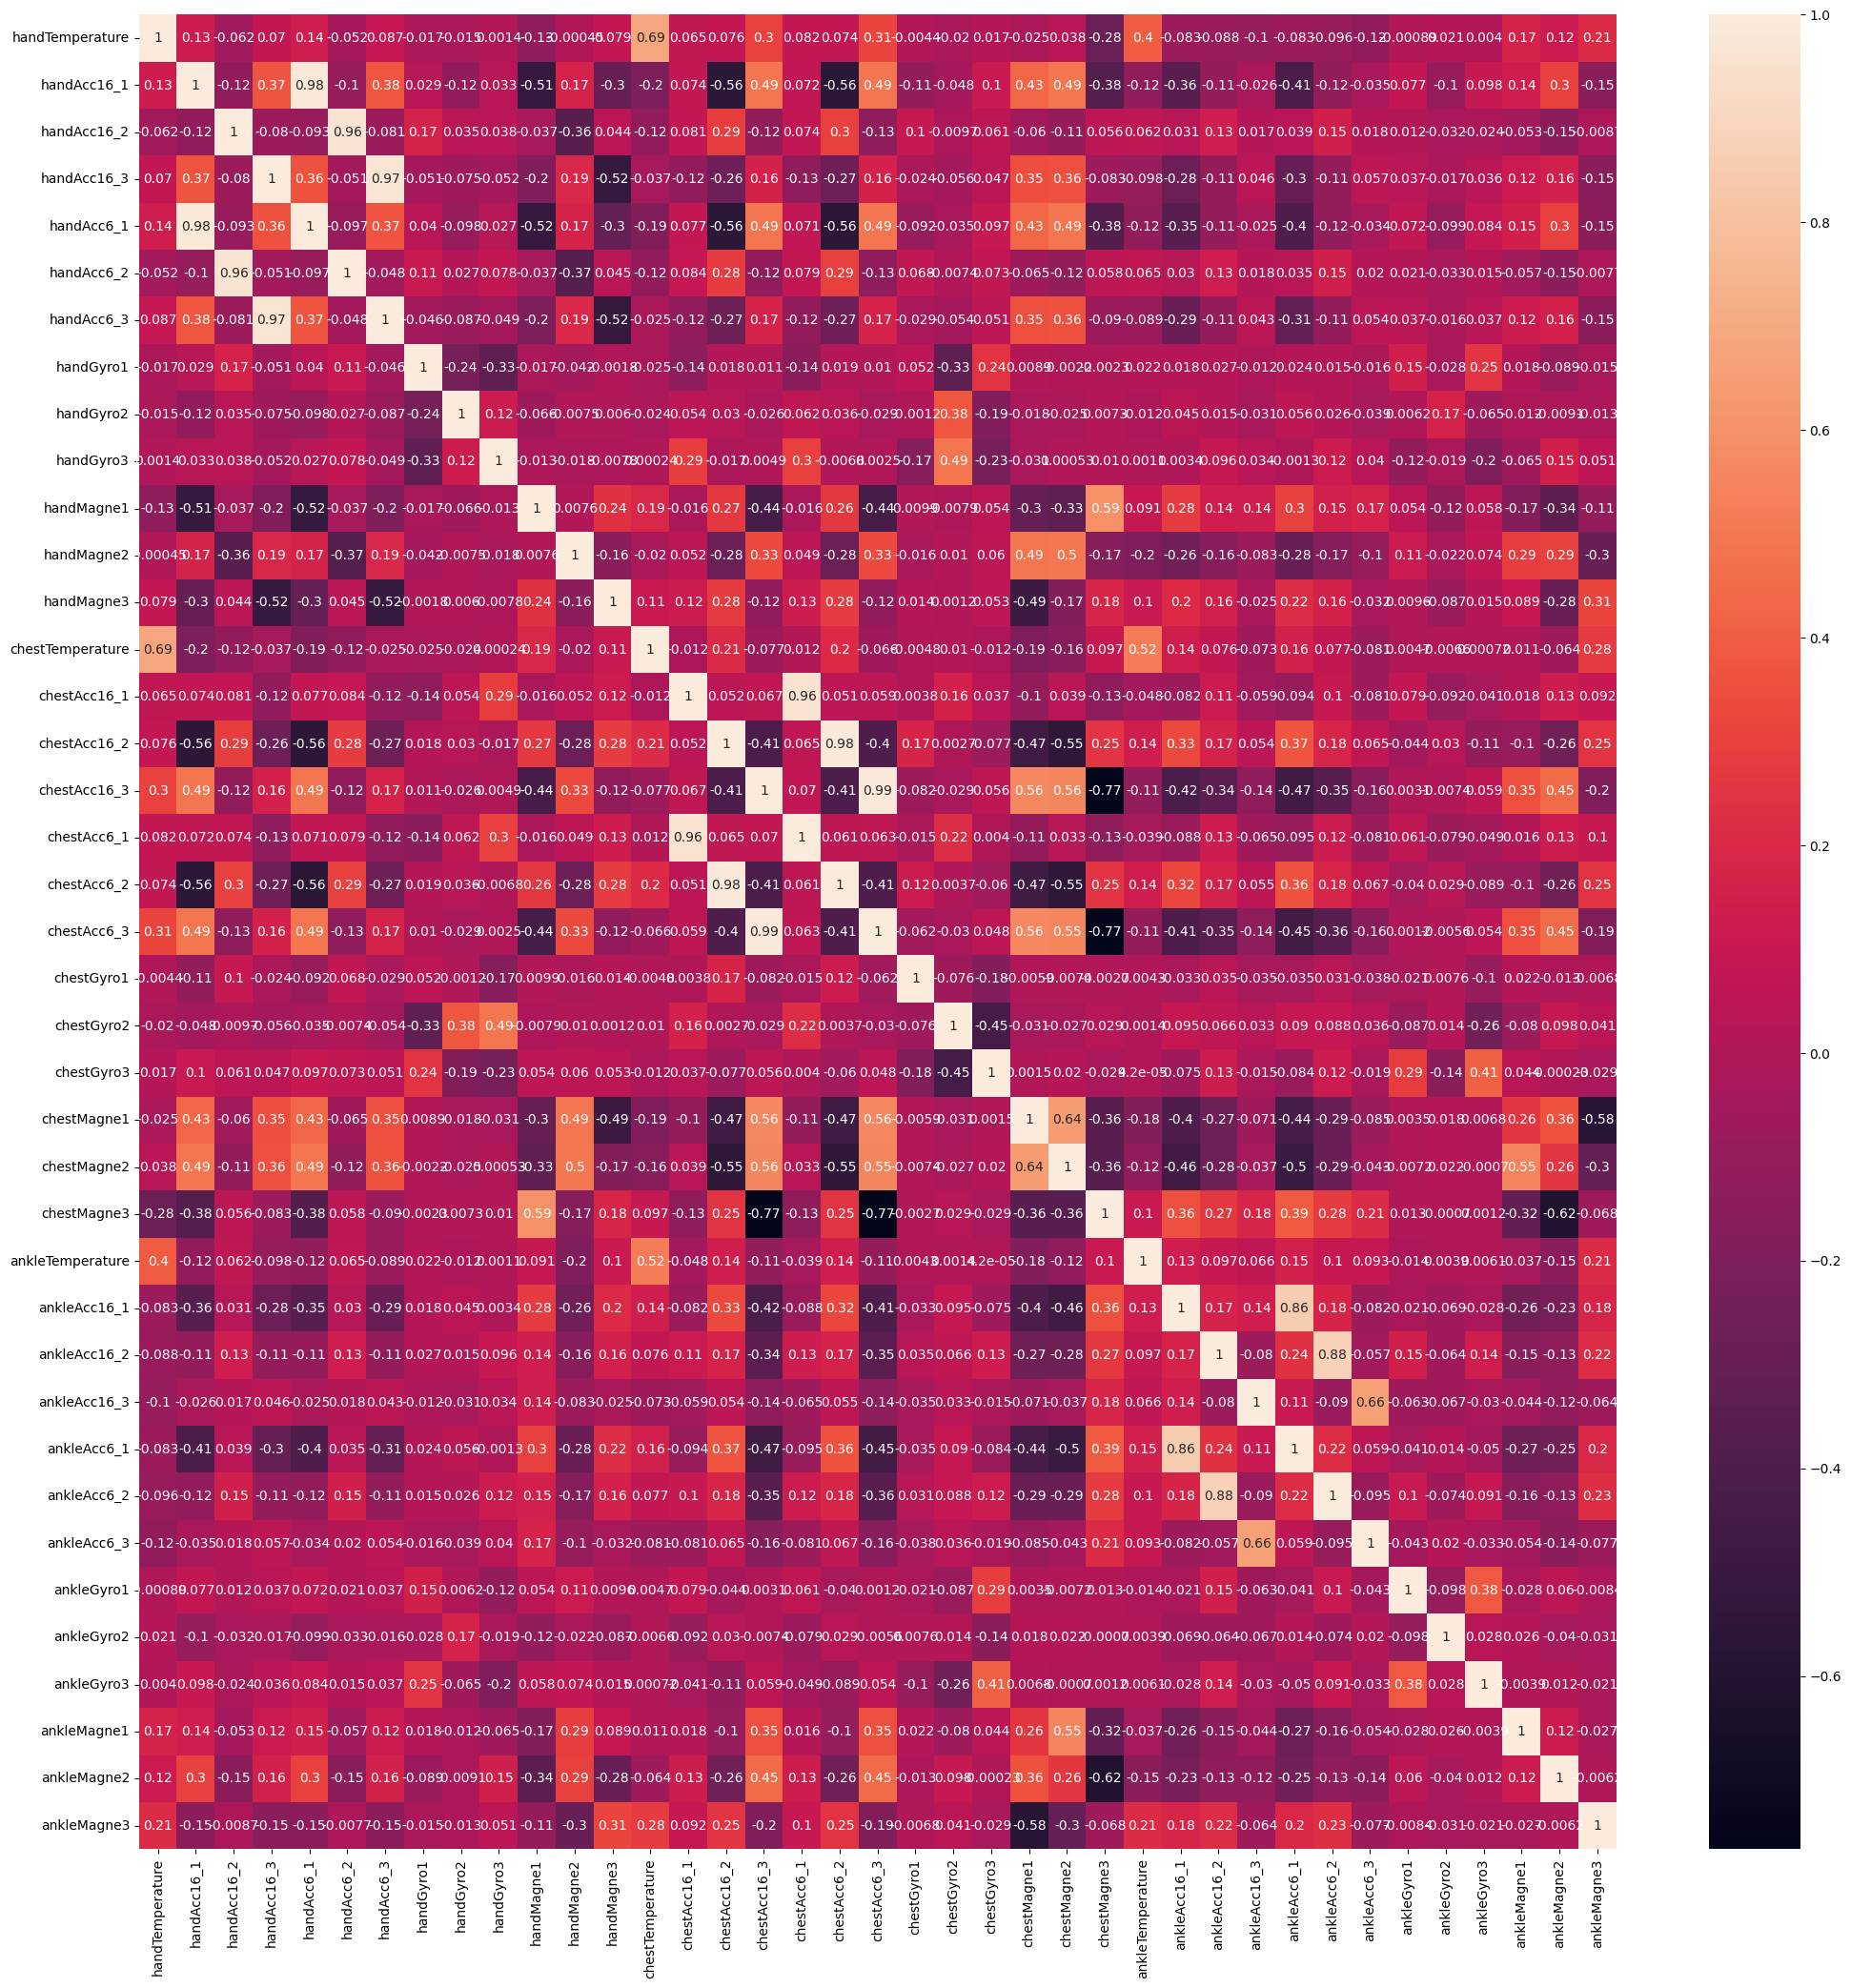

In [15]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.drop(['timestamp', 'subject_id'], axis=1).corr(), annot=True)

Видим следующую картину:
1) Сильная корреляция между 3D ускорением на 6 и 16 грамм. Следовательно, нужно удалить один из столбцов;
2) Сильная корреляциям между магнитометром на груди и аксельометром на 6 грамм.

Соединяя данные 2 вывода удалим более чувствительноый аксельометр на 6 грамм.

In [16]:
df.drop(columns=['handAcc6_1', 'handAcc6_2', 'handAcc6_3',
                 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3'], axis=1, inplace=True)
df_smoothed.drop(columns=['handAcc6_1', 'handAcc6_2', 'handAcc6_3',
                 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3'], axis=1, inplace=True)

<Axes: >

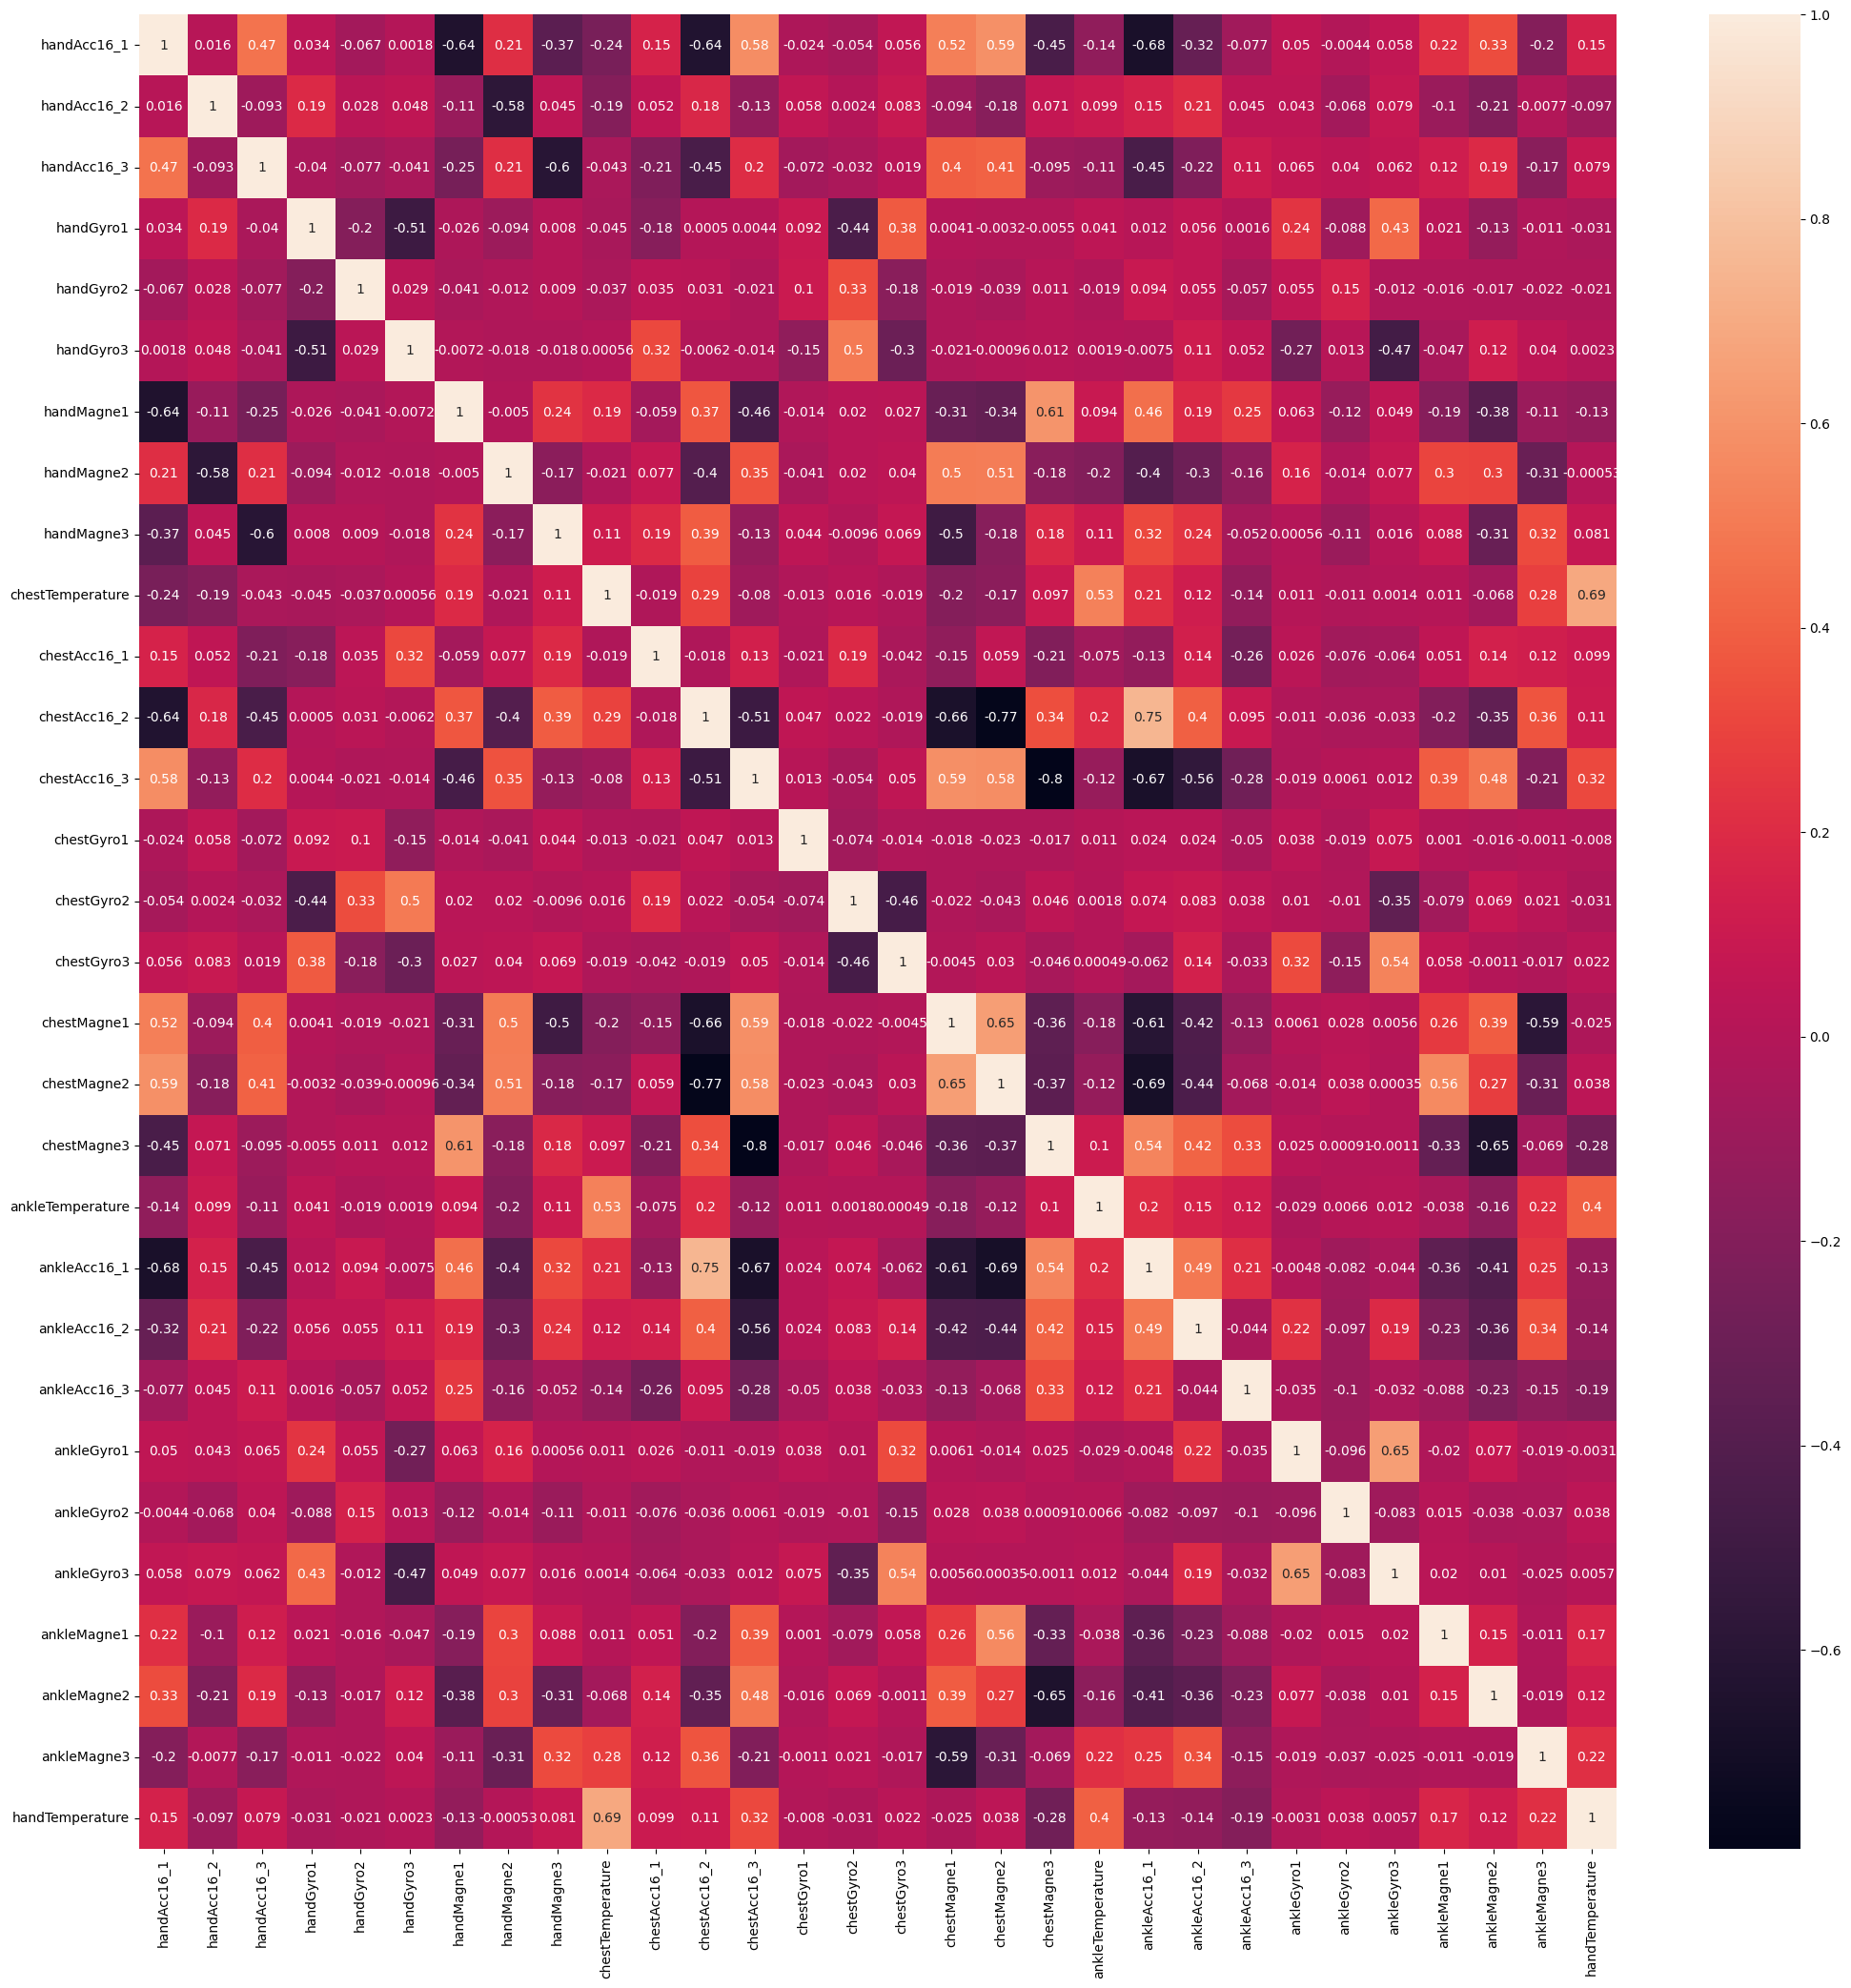

In [17]:
plt.figure(figsize=(25, 25))
sns.heatmap(df_smoothed.drop(['timestamp', 'subject_id'], axis=1).corr(), annot=True)

Температура также коррелирует между собой, а т. к. это может быть плохо для некоторых моделей попробуем создать синтетический показатель температуры, который покажет совместит эти 3 показателя в один. Коэффициенты подобраны с учетом теоретической логики (на груди измерения более надежные)

In [18]:
df['temperature'] = df['ankleTemperature']*0.1+df['handTemperature']*0.2+df['chestTemperature']*0.7
df.drop(columns=['ankleTemperature', 'handTemperature', 'chestTemperature'], axis=1, inplace=True)

df_smoothed['temperature'] = df_smoothed['ankleTemperature']*0.1+df_smoothed['handTemperature']*0.2+df_smoothed['chestTemperature']*0.7
df_smoothed.drop(columns=['ankleTemperature', 'handTemperature', 'chestTemperature'], axis=1, inplace=True)

Стоит также соединить все показатели в один по евклидовой метрике.

In [19]:
df['handAcc16'] = np.sqrt(df['handAcc16_1']**2+df['handAcc16_2']**2+df['handAcc16_3']**2)
df_smoothed['handAcc16'] = np.sqrt(df_smoothed['handAcc16_1']**2+df_smoothed['handAcc16_2']**2+df_smoothed['handAcc16_3']**2)

df['handGyro'] = np.sqrt(df['handGyro1']**2+df['handGyro2']**2+df['handGyro3']**2)
df_smoothed['handGyro'] = np.sqrt(df_smoothed['handGyro1']**2+df_smoothed['handGyro2']**2+df_smoothed['handGyro3']**2)

df['handMagne'] = np.sqrt(df['handMagne1']**2+df['handMagne2']**2+df['handMagne3']**2)
df_smoothed['handMagne'] = np.sqrt(df_smoothed['handMagne1']**2+df_smoothed['handMagne2']**2+df_smoothed['handMagne3']**2)

df['chestAcc'] = np.sqrt(df['chestAcc16_1']**2+df['chestAcc16_2']**2+df['chestAcc16_3']**2)
df_smoothed['chestAcc'] = np.sqrt(df_smoothed['chestAcc16_1']**2+df_smoothed['chestAcc16_2']**2+df_smoothed['chestAcc16_3']**2)

df['chestGyro'] = np.sqrt(df['chestGyro1']**2+df['chestGyro2']**2+df['chestGyro3']**2)
df_smoothed['chestGyro'] = np.sqrt(df_smoothed['chestGyro1']**2+df_smoothed['chestGyro2']**2+df_smoothed['chestGyro3']**2)

df['chestMagne'] = np.sqrt(df['chestMagne1']**2+df['chestMagne2']**2+df['chestMagne3']**2)
df_smoothed['chestMagne'] = np.sqrt(df_smoothed['chestMagne1']**2+df_smoothed['chestMagne2']**2+df_smoothed['chestMagne3']**2)

df['ankleAcc'] = np.sqrt(df['ankleAcc16_1']**2+df['ankleAcc16_2']**2+df['ankleAcc16_3']**2)
df_smoothed['ankleAcc'] = np.sqrt(df_smoothed['ankleAcc16_1']**2+df_smoothed['ankleAcc16_2']**2+df_smoothed['ankleAcc16_3']**2)

df['ankleGyro'] = np.sqrt(df['ankleGyro1']**2+df['ankleGyro2']**2+df['ankleGyro3']**2)
df_smoothed['ankleGyro'] = np.sqrt(df_smoothed['ankleGyro1']**2+df_smoothed['ankleGyro2']**2+df_smoothed['ankleGyro3']**2)

df['ankleMagne'] = np.sqrt(df['ankleMagne1']**2+df['ankleMagne2']**2+df['ankleMagne3']**2)
df_smoothed['ankleMagne'] = np.sqrt(df_smoothed['ankleMagne1']**2+df_smoothed['ankleMagne2']**2+df_smoothed['ankleMagne3']**2)


df.drop(['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1',
       'handGyro2', 'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3',
       'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestGyro1',
       'chestGyro2', 'chestGyro3', 'chestMagne1', 'chestMagne2', 'chestMagne3',
       'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1',
       'ankleGyro2', 'ankleGyro3', 'ankleMagne1', 'ankleMagne2', 'ankleMagne3'], axis=1, inplace=True)
df_smoothed.drop(['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1',
       'handGyro2', 'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3',
       'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestGyro1',
       'chestGyro2', 'chestGyro3', 'chestMagne1', 'chestMagne2', 'chestMagne3',
       'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1',
       'ankleGyro2', 'ankleGyro3', 'ankleMagne1', 'ankleMagne2', 'ankleMagne3'], axis=1, inplace=True)

In [20]:
df.columns

Index(['timestamp', 'subject_id', 'temperature', 'handAcc16', 'handGyro',
       'handMagne', 'chestAcc', 'chestGyro', 'chestMagne', 'ankleAcc',
       'ankleGyro', 'ankleMagne'],
      dtype='object')

Запомним тот факт, что есть мультиколлинеарность между 3D ускорением на груди и магнитометром на груди и двинемся дальше

Необходимо выбрать количество кластеров для моделирования

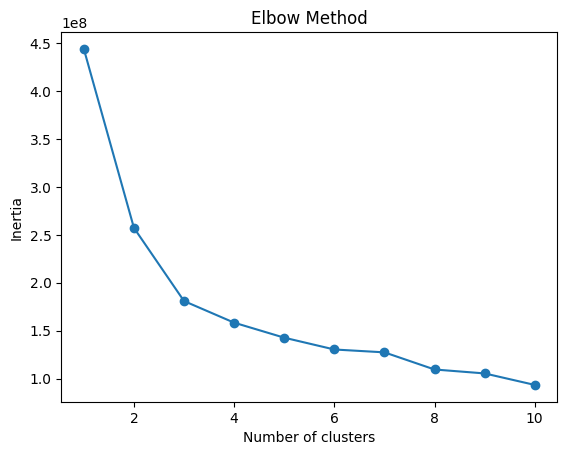

In [21]:
X = df.drop(['timestamp'], axis=1)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
X = df_smoothed.drop(['timestamp'], axis=1)

inertia = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 21), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Метод локтя, как и в baseline ни привел к однозначным выводам. Воспользуемся силуетами

Алгоритм силуэта на этом датасете очень долгий, поэтому возьмем только 10000 элементов

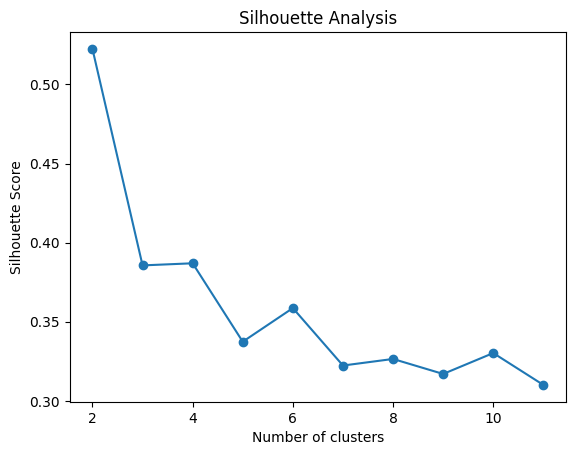

In [22]:
X = df_smoothed.drop(['timestamp'], axis=1)

X_sample = resample(X, n_samples=min(10000, len(X)), random_state=42)

silhouette_scores = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    silhouette_scores.append(silhouette_score(X_sample, labels))

plt.plot(range(2, 12), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.show()

Далее проанализируем так, как учили в курсе.

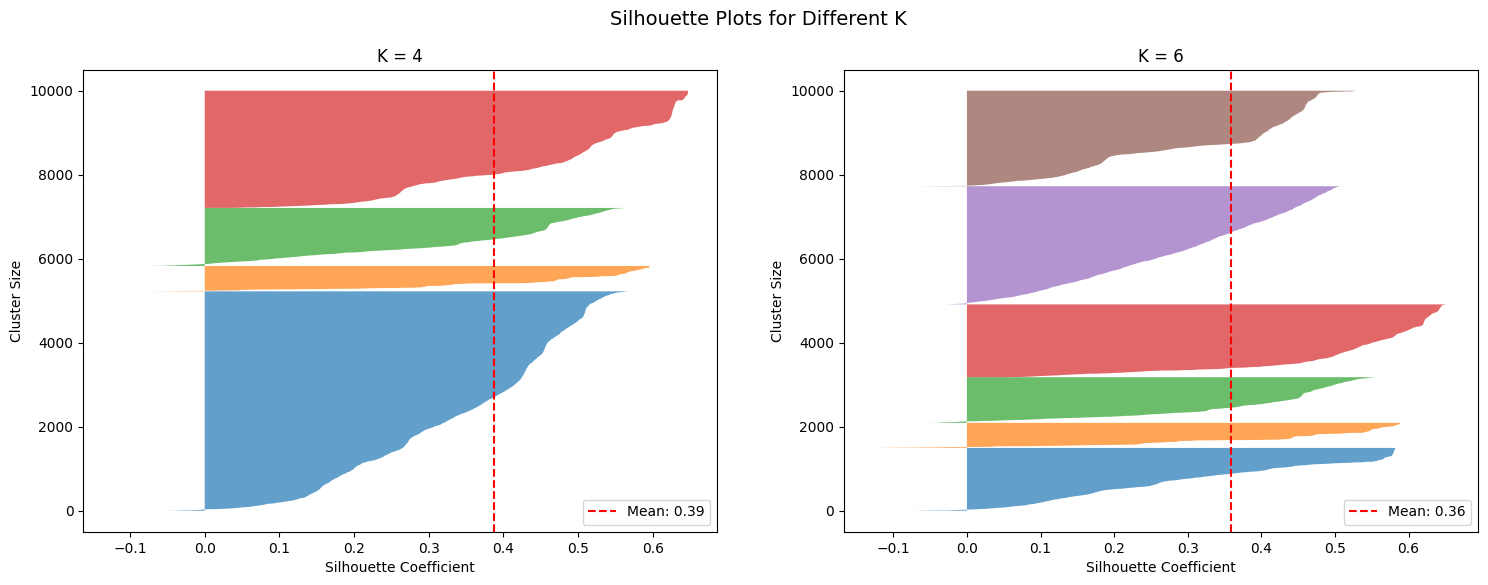

In [26]:
# Функция для построения силуэтных графиков
def plot_silhouette(X, cluster_counts):
    fig, axes = plt.subplots(1, len(cluster_counts), figsize=(18, 6))

    for idx, K in enumerate(cluster_counts):
        kmeans = KMeans(n_clusters=K, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        # Вычисляем силуэтные коэффициенты
        silhouette_vals = silhouette_samples(X, cluster_labels)

        y_lower, y_upper = 0, 0
        axes[idx].set_title(f"K = {K}")
        
        for i in range(K):
            cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
            cluster_silhouette_vals.sort()

            y_upper += len(cluster_silhouette_vals)
            axes[idx].fill_betweenx(
                np.arange(y_lower, y_upper), 
                0, 
                cluster_silhouette_vals, 
                alpha=0.7
            )
            y_lower = y_upper
        
        # Средний силуэтный коэффициент
        avg_score = silhouette_score(X, cluster_labels)
        axes[idx].axvline(avg_score, linestyle="--", color="red", label=f"Mean: {avg_score:.2f}")
        axes[idx].legend()
        axes[idx].set_xlabel("Silhouette Coefficient")
        axes[idx].set_ylabel("Cluster Size")
    
    plt.suptitle("Silhouette Plots for Different K", fontsize=14)
    plt.show()

# Вызываем функцию для K=6, 7, 8
plot_silhouette(X_sample, cluster_counts=[4, 6])

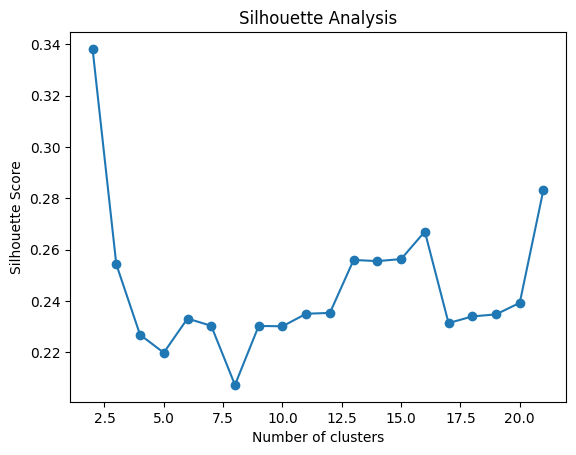

In [24]:
X = df.drop(['timestamp'], axis=1)
X_sample = resample(X, n_samples=min(10000, len(X)), random_state=42)

silhouette_scores = []
for k in range(2, 22):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    silhouette_scores.append(silhouette_score(X_sample, labels))

plt.plot(range(2, 22), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.show()

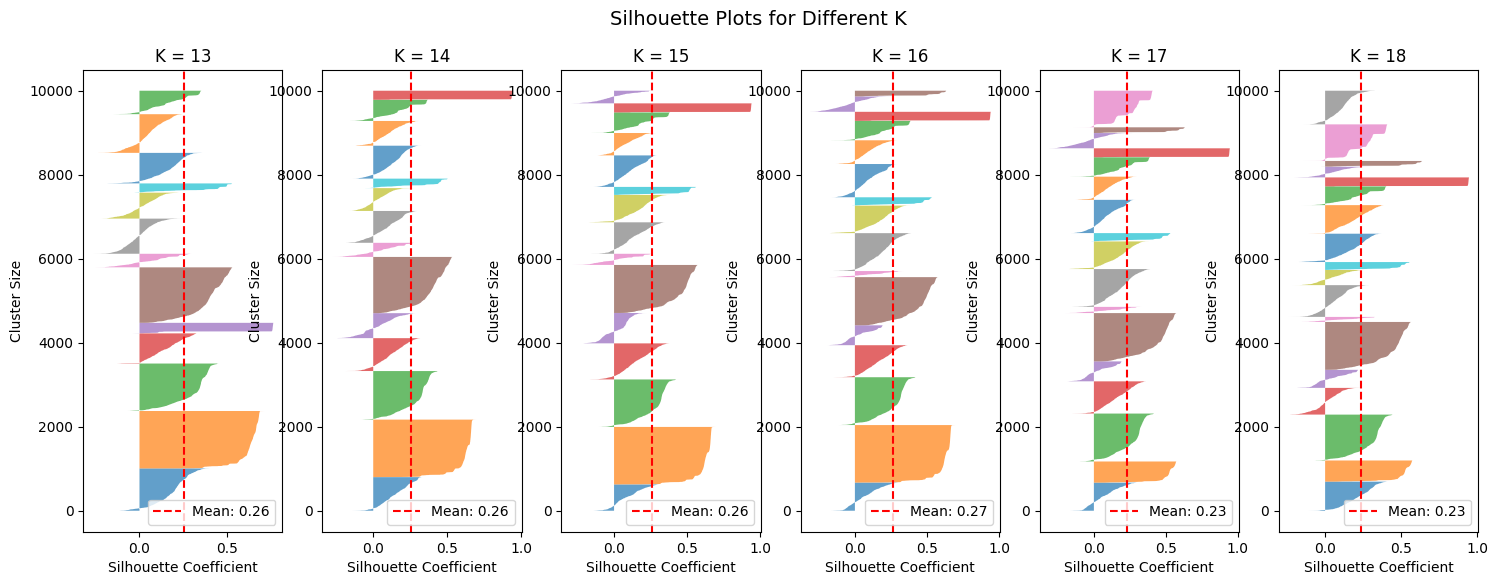

In [25]:
# Функция для построения силуэтных графиков
def plot_silhouette(X, cluster_counts):
    fig, axes = plt.subplots(1, len(cluster_counts), figsize=(18, 6))

    for idx, K in enumerate(cluster_counts):
        kmeans = KMeans(n_clusters=K, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        # Вычисляем силуэтные коэффициенты
        silhouette_vals = silhouette_samples(X, cluster_labels)

        y_lower, y_upper = 0, 0
        axes[idx].set_title(f"K = {K}")
        
        for i in range(K):
            cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
            cluster_silhouette_vals.sort()

            y_upper += len(cluster_silhouette_vals)
            axes[idx].fill_betweenx(
                np.arange(y_lower, y_upper), 
                0, 
                cluster_silhouette_vals, 
                alpha=0.7
            )
            y_lower = y_upper
        
        # Средний силуэтный коэффициент
        avg_score = silhouette_score(X, cluster_labels)
        axes[idx].axvline(avg_score, linestyle="--", color="red", label=f"Mean: {avg_score:.2f}")
        axes[idx].legend()
        axes[idx].set_xlabel("Silhouette Coefficient")
        axes[idx].set_ylabel("Cluster Size")
    
    plt.suptitle("Silhouette Plots for Different K", fontsize=14)
    plt.show()

# Вызываем функцию для K=6, 7, 8
plot_silhouette(X_sample, cluster_counts=[13, 14, 15, 16, 17, 18])

Исходя из анализа силуэтов я бы остановился на 16 кластерах. На то есть несколько причин:
1) Самый высокий показатель силуэта - 0.28361;
2) Ножи длинные, отрицательных значений немного.

# Моделирование

В качетсве модели попробуем K-means, а в качетсве df - df_smoothed

In [36]:
# Пример данных (замените на свои)
X = df.drop(['timestamp'], axis=1)

# Пайплайн: масштабирование → нормализация → KMeans
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация (центрирование и масштабирование)
    ('kmeans', KMeans(random_state=42, n_clusters=4))
])

pipeline.fit(X)

pipeline.predict(X)

array([1, 1, 1, ..., 1, 1, 3], dtype=int32)

Здесь я засабмитил и увидел ужасное качество модели (считать силуэты - это очень долго на этом наборе). Поэтому попробовал некоторые изменения и пересчитал результат, стал чуть получше. Baseline для этого задания я не нашел, поэтому оставлю так. Если появится возможность доделать, то переделаю и отредактирую ответ.

# Предсказание

In [37]:
df['clusters'] = pipeline.predict(X)

In [38]:
df_raw = pd.read_csv('./data/Physical_Activity_Monitoring_unlabeled.csv')
df_raw

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.54470,27.3336,-5.766200,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.82570,-15.7719,-1.313950,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.81710,16.3089,25.292800,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.74180,34.3566,21.327400,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.77980,-3.9981,10.995000,0.171133,-0.748343,0.252988,-0.588807,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534596,3479.53,33.8750,-9.084250,4.70122,2.890170,-9.689610,6.78077,3.975430,-0.157406,0.774189,...,0.424520,-0.856836,-25.00990,-23.5557,23.615300,0.318171,-0.701921,0.555778,-0.311745,5
534597,2448.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.767710,-3.050980,-35.70240,31.8018,16.421800,0.435887,0.660643,0.371665,0.485200,5
534598,2479.84,34.6875,-6.367550,2.32131,2.207640,-6.362460,2.33049,2.607610,0.206349,-0.359415,...,-0.034144,-0.402013,-49.69220,20.6039,-0.917908,0.561652,0.297957,0.756767,0.151899,5
534599,3437.82,28.0625,5.461940,10.43640,-9.073300,8.348860,5.76518,-6.143210,3.543910,2.757300,...,0.352062,-5.577750,-34.15510,-11.0786,39.737500,0.062163,-0.798705,-0.056668,-0.595815,6


In [39]:
df_predict = df_raw.join(df['clusters'], how='left')

In [40]:
df_predict['clusters'].unique()

array([2, 0, 1, 3], dtype=int32)

In [42]:
df_predict['activityID'] = df_predict['clusters'].replace({2:0, 0:1, 1:2, 3:3})

In [43]:
df_predict['activityID'].to_csv('./data/predict1.csv')